# Tarea Semanal 5

Diseñar un filtro pasabanda que cumpla con la siguiente plantilla:

<img src="./Plantilla PBF Transferencia.png" width="70%" height="70%" align="left"/>

* $\omega_0 = 2\pi·22kHz$ 
* $Q = 5$  
* $\alpha_\text{máx} = 0.5dB$ (Chebyshev)
<br/>

* $f_{s1}=17kHz$
* $f_{s2}=36kHz$
* $\left|T\left(f_{s1}\right)\right|=-16dB \quad \Longrightarrow \quad \alpha_{\text{mín}}\left(f_{s1}\right)=16dB$
* $\left|T\left(f_{s2}\right)\right|=-24dB \quad \Longrightarrow \quad \alpha_{\text{mín}}\left(f_{s2}\right)=24dB$

In [2]:
import numpy as np
import sympy as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
from matplotlib import patches
from IPython.display import display,Math
from pytc2.sistemas_lineales import pzmap, bodePlot

## 1. Obtener la plantilla de diseño pasabanda normalizada

### Obtención de frecuencias de corte inferior y superior

$\omega_0^2 = \omega_1 \omega_2 \Rightarrow \omega_1 \omega_2 - \omega_0^2 = 0$

$Q = \frac{\omega_0}{\omega_2-\omega_1} \Rightarrow \omega_2 - \omega_1 - \frac{\omega_0}{Q} = 0$

In [3]:
w1,w2 = sp.symbols("omega_1,omega_2")
w0 = 1
Q = 5

eq1 = w1*w2-w0**2
eq2 = w2-w1-w0/Q
sol1 = sp.solve([eq1,eq2],[w1,w2])

w1 = sol1[1][0]
w2 = sol1[1][1]

display(Math(r'\text{Frecuencias de corte normalizadas}: \newline\omega_1=' + str(w1) + r'\newline \omega_2=' + str(w2)))

<IPython.core.display.Math object>

## 2. Obtener la función transferencia normalizada del prototipo pasabajo que satisfaga el requerimiento del filtro pasabanda.


### Obtención de parámetros de la plantilla pasabajos

Pasos según Schaumann:

1. Hallar $\varepsilon,n$
2. Hallar $a$
3. Hallar ubicación de los polos

$\varepsilon^2 = 10^{\frac{\alpha_\text{máx}}{10}}-1$

In [4]:
alpha_max = 0.5
eps2 = 10**(alpha_max/10)-1
eps = eps2**0.5

display(Math(r'\varepsilon^2=' + str(eps2) + r'\newline\varepsilon=' + str(eps)))

<IPython.core.display.Math object>

Para transformar la plantilla pasabanda a pasabajos, se debe calcular la frecuencia de inicio de la banda de corte $\Omega_S$, a partir de las $\omega_S$ de la plantilla inicial.

Como $\omega_{S1}\omega_{S2} \neq \omega_0$, será necesario calcular ambas frecuencias para obtener el orden que impone la atenuación requerida en cada extremo. Como el procedimiento contempla la transformación de una única plantilla pasabajos en una pasabanda, se aplicará el orden que resulte mayor.

$\Omega_S = Q\frac{\omega_s^2-1}{\omega_s}$

In [5]:
ws = sp.symbols("omega_s")
WS = Q*(ws**2-1)/ws
ws1 = 17/22
ws2 = 36/22

WS1 = np.double(WS.subs(ws,ws1)*-1) #Ignorar el signo de la frecuencia de corte inferior (P.360)
WS2 = np.double(WS.subs(ws,ws2))

display(Math(r'\Omega_{S1}=' + str(WS1) + r'\newline\Omega_{S2}=' + str(WS2)))

<IPython.core.display.Math object>

$\alpha_{\text{mín}} = 10\log_{10}\left\{1+\varepsilon^2\cosh^2\left[n\cosh^{-1}\left(\omega_S\right)\right]\right\}$

In [6]:
n = sp.symbols('n')
alpha_min = 10*sp.log(1+eps2*sp.cosh(n*sp.acosh(ws))**2,10)

alpha_min1 = [np.double(alpha_min.subs({n:N,ws:WS1})) for N in range(1,6)]
alpha_min2 = [np.double(alpha_min.subs({n:N,ws:WS2})) for N in range(1,6)]

for N in range(1,6):
    display(Math(r'n = ' + str(N) \
                 + r':\quad\alpha_\text{mín1} = ' + str(alpha_min1[N-1]) + r'\text{dB},' \
                 + r'\quad\alpha_\text{mín2} = ' + str(alpha_min2[N-1]) + r'\text{dB}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Como $\alpha_\text{mín1}=16dB$ y $\alpha_\text{mín2}=24dB$, el orden mínimo que cumple con ambos requerimientos es $n=3$

$a = \frac{1}{n}\sinh^{-1}\left(\frac{1}{\varepsilon}\right)$

$\sigma_k = -\sinh\left(a\right)·\sin\left(\frac{2k-1}{2n}\pi\right)$

$\omega_k = \cosh\left(a\right)·\cos\left(\frac{2k-1}{2n}\pi\right)$

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

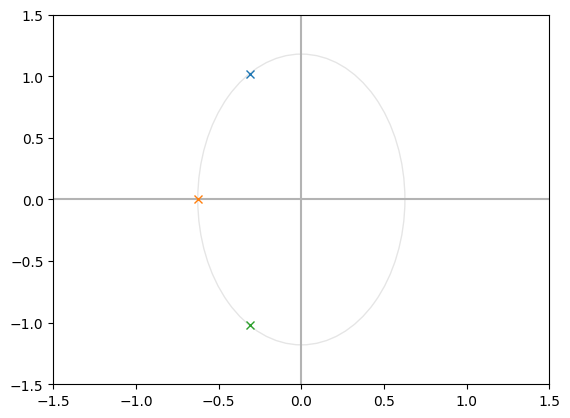

In [7]:
k,n = sp.symbols("k,n")

N = 3
a = 1/N * np.arcsinh(1/eps)

sigma_k = -sp.sinh(a)*sp.sin((2*k-1)/(2*n)*np.pi)
omega_k = sp.cosh(a)*sp.cos((2*k-1)/(2*n)*np.pi)
polos = [complex((sigma_k + 1j*omega_k).subs({n:N,k:K})) for K in range(1,N+1)]

lim = 1.5
fig,ax = plt.subplots()
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])
plt.axvline(0,color='0.7')
plt.axhline(0,color='0.7')
ax.add_patch(patches.Ellipse((0,0),2*np.sinh(a),2*np.cosh(a),fill=False,alpha=0.1))

display(Math(r'a = ' + str(a)))
for n in range(N):
    display(Math(r'\text{Polo }' + str(n+1) + ': ' + str(polos[n])))
    plt.plot(polos[n].real,polos[n].imag,'x')

$\omega_{0k} = \sqrt{\omega_k^2+\sigma_k^2}$

$q_k = \frac{\omega_{0k}}{2\sigma_k}$

In [8]:
w0_cc = np.sqrt(np.real(polos[0])**2 + np.imag(polos[0])**2)
q_cc = -w0_cc/(2*np.real(polos[0]))

print(w0_cc)
print(q_cc)

1.0688534648293948
1.7061894770594206


### Transferencia pasabajos

$T(S) = \frac{a}{S+a} \frac{c}{S^2+S b+c}$

$a = \omega_0$ del polo simple

$b = \frac{\omega_0}{q}$ de los polos complejos conjugados

$c = \omega_0^2$ de los polos complejos conjugados

In [9]:
a = np.abs(np.real(polos[1]))
b = w0_cc/q_cc
c = w0_cc**2

print(a)
print(b)
print(c)

0.6264564863402745
0.6264564863402744
1.1424477292778024


In [10]:
S = sp.symbols("S")
T_lp_ps = a/(S+a)
T_lp_pcc = c/(S**2 + S*b + c)
T_lp = T_lp_ps*T_lp_pcc

display(Math(r'\text{Transferencia de polo simple}: T(S) = ' + sp.latex(T_lp_ps)))
display(Math(r'\text{Transferencia de polos complejos conjugados}: T(S) = ' + sp.latex(T_lp_pcc)))
display(Math(r'\text{Transferencia pasabajos normalizada}: T(S) = ' + sp.latex(sp.expand(T_lp))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## 3. Obtener la transferencia pasabanda normalizada


### Transformación pasabajos - pasabanda

Núcleo de transformación: $S = Q \frac{s^2+1}{s}$

$T_{BP}\left(s\right) = T_{LP}\left(S\right)\rvert_{S = Q\frac{s^2+1}{s}}$

In [11]:
s = sp.symbols("s")
LP_BP = Q*(s**2+1)/s

T_bp_ps = sp.simplify(T_lp_ps.subs(S,LP_BP))
T_bp_pcc = sp.simplify(T_lp_pcc.subs(S,LP_BP))
T_bp = sp.simplify(T_lp.subs(S,LP_BP))

display(Math(r'\text{Transferencia de polo simple}: \newline T(S) = ' + sp.latex(T_bp_ps)))
display(Math(r'\text{Transferencia de polos complejos conjugados}: \newline T(S) = ' + sp.latex(T_bp_pcc)))
display(Math(r'\text{Transferencia pasabajos normalizada}: T(S) = \newline' + sp.latex(sp.expand(T_bp))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
num,den = sp.fraction(T_bp)
num = np.array(sp.Poly(num).all_coeffs())
den = np.array(sp.Poly(den).all_coeffs())
Tf_bp = sig.TransferFunction(np.array(num,dtype=float),np.array(den,dtype=float))

polos = np.roots(den)

for n in range(0,len(polos)):
    display(Math(r'\text{Polo }' + str(n) + ': ' + str(polos[n])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(2,
 array([<Axes: title={'center': 'Magnitude response'}, ylabel='Magnitude [dB]'>,
        <Axes: title={'center': 'Phase response'}, xlabel='Angular frequency [rad/sec]', ylabel='Phase [rad]'>],
       dtype=object))

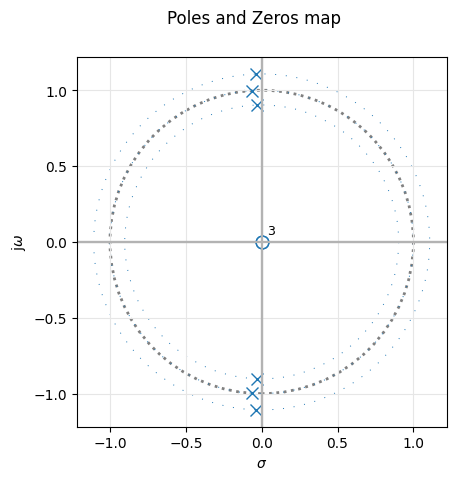

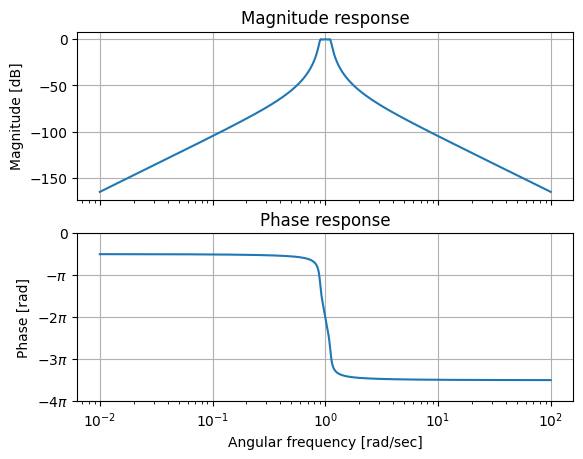

In [13]:
pzmap(Tf_bp)
bodePlot(Tf_bp)

## 4. Implementar mediante secciones pasivas separadas por seguidores de tensión activos.


In [14]:
def get_w0k(polo:complex):
    w0 = np.sqrt(np.real(polo)**2 + np.imag(polo)**2)
    q = w0/(2*np.abs(np.real(polo)))
    return w0,q

In [15]:
for i in range(3):
    w0,q = get_w0k(polos[i*2])
    display(Math(r'\omega_{0' + str(i) + r'} = ' + str(w0) + r';\quad q_{' + str(i) + '} = ' + str(q)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Para la implementación, se requieren tres pares de polos complejos conjugados y tres ceros en el origen.

Se utilizarán tres secciones RLC con LC serie y R en derivación, cuya transferencia es:

$T\left(s\right) = \large\frac{s\frac{R}{L}}{s^2 + s\frac{R}{L} + \frac{1}{LC}} \normalsize = \large \frac{s\frac{\omega_0}{q}}{s^2 + s\frac{\omega_0}{q} + \omega_0^2}$

Para las cuales una aproximación inicial de diseño fija:

$\left\{C=1 \quad L = \frac{1}{\omega_0^2}\quad R = \frac{q}{\omega_0} \right\}$

In [19]:
W_Z = 1e3
W_w = 2*np.pi*22e3

for i in range(3):
    w0,q = get_w0k(polos[i*2])
    R = q/w0
    L = 1/(w0**2)
    C = 1
    display(Math(r'R_' + str(i+1) + ' = ' + str(R) + \
                 r'\qquad L_' + str(i+1) + ' = ' + np.format_float_scientific(L) + \
                 r'\qquad C_' + str(i+1) + ' = ' + np.format_float_scientific(C)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Desnormalización

$\Omega_Z = 1k\Omega \quad \Omega_\omega = 2\pi 22kHz$

$R = R_n · \Omega_Z \quad C = C_n \frac{1}{\Omega_Z \Omega_\omega} \quad L = L_n \frac{\Omega_Z}{\Omega_\omega} $

(1,
 array([<Axes: title={'center': 'Magnitude response'}, ylabel='Magnitude [dB]'>,
        <Axes: title={'center': 'Phase response'}, xlabel='Angular frequency [rad/sec]', ylabel='Phase [rad]'>],
       dtype=object))

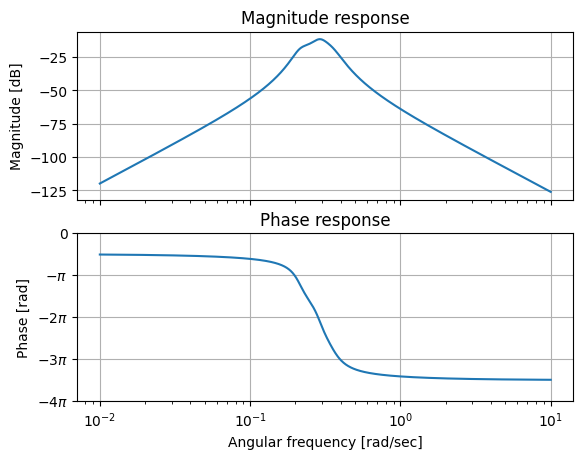

In [20]:
num = [1]
den = [1]
for i in range(3):
    w0,q = get_w0k(polos[i*2])
    R = q/w0
    L = 1/(w0**2)
    C = 1
    num = np.polymul(num,[1/(R*C),0])
    den = np.polymul(den,[1,1/(R*C),1/(R*L*C)])
    
bodePlot(sig.TransferFunction(num,den))

## 5. Activar las redes pasivas mediante la red propuesta aquí debajo y comprobar mediante simulación el comportamiento deseado.